# Brain MRI Tumor Classification 
### Identification of brain tumors with a convolutional neural network and transfer learning

In [9]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [10]:
from keras.utils import to_categorical
from keras import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense

In [11]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [12]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('input','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    folderPath = os.path.join('input','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)


100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 194.22it/s]


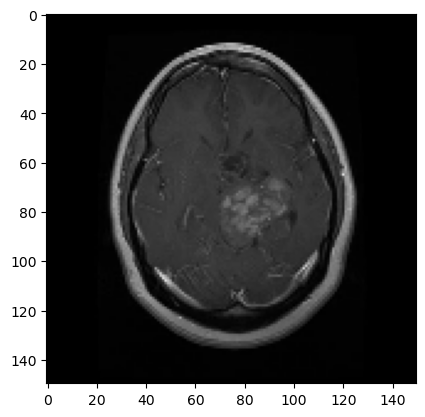

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.show()

In [14]:
X_train, y_train = shuffle(X_train, y_train)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1 )

In [15]:
y_train.shape

(2937,)

In [16]:
y_test.shape

(327,)

In [17]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
cnn = Sequential([
        # ccn network
        Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Convolution2D(filters=64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        # dense network
        Flatten(),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax')
])

In [19]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
           )

In [20]:
cnn.fit(X_train, y_train, validation_split=0.1, epochs=10, verbose=1, batch_size=32)

Epoch 1/10
83/83 [==============================] - 22s 262ms/step - loss: 40.1789 - accuracy: 0.5142 - val_loss: 0.6797 - val_accuracy: 0.7007
Epoch 2/10
83/83 [==============================] - 23s 283ms/step - loss: 0.4876 - accuracy: 0.8176 - val_loss: 0.4893 - val_accuracy: 0.8367
Epoch 3/10
83/83 [==============================] - 24s 292ms/step - loss: 0.1692 - accuracy: 0.9448 - val_loss: 0.3974 - val_accuracy: 0.8571
Epoch 4/10
83/83 [==============================] - 24s 294ms/step - loss: 0.0747 - accuracy: 0.9815 - val_loss: 0.4579 - val_accuracy: 0.8707
Epoch 5/10
83/83 [==============================] - 25s 295ms/step - loss: 0.0250 - accuracy: 0.9939 - val_loss: 0.5770 - val_accuracy: 0.8571
Epoch 6/10
83/83 [==============================] - 24s 294ms/step - loss: 0.0323 - accuracy: 0.9936 - val_loss: 0.5777 - val_accuracy: 0.8605
Epoch 7/10
83/83 [==============================] - 24s 293ms/step - loss: 0.0131 - accuracy: 0.9981 - val_loss: 0.5767 - val_accuracy: 0.877

In [22]:
# save model
save_path = './base_model.h5'
cnn.save(save_path)

In [23]:
loaded_model = tf.keras.models.load_model(save_path)

In [24]:
y_pred = loaded_model.predict(X_test)

11/11 [==============================] - 1s 56ms/step


In [32]:
y_pred = cnn.predict(X_test)

11/11 [==============================] - 1s 56ms/step


In [36]:
from sklearn.metrics import confusion_matrix, classification_report

In [38]:
print(classification_report(y_test_new,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        97
           1       0.78      0.77      0.77        56
           2       0.79      0.82      0.81        91
           3       0.94      0.94      0.94        83

    accuracy                           0.86       327
   macro avg       0.85      0.85      0.85       327
weighted avg       0.86      0.86      0.86       327



In [34]:
y_pred = np.argmax(y_pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

confusion_matrix(y_test, y_pred)

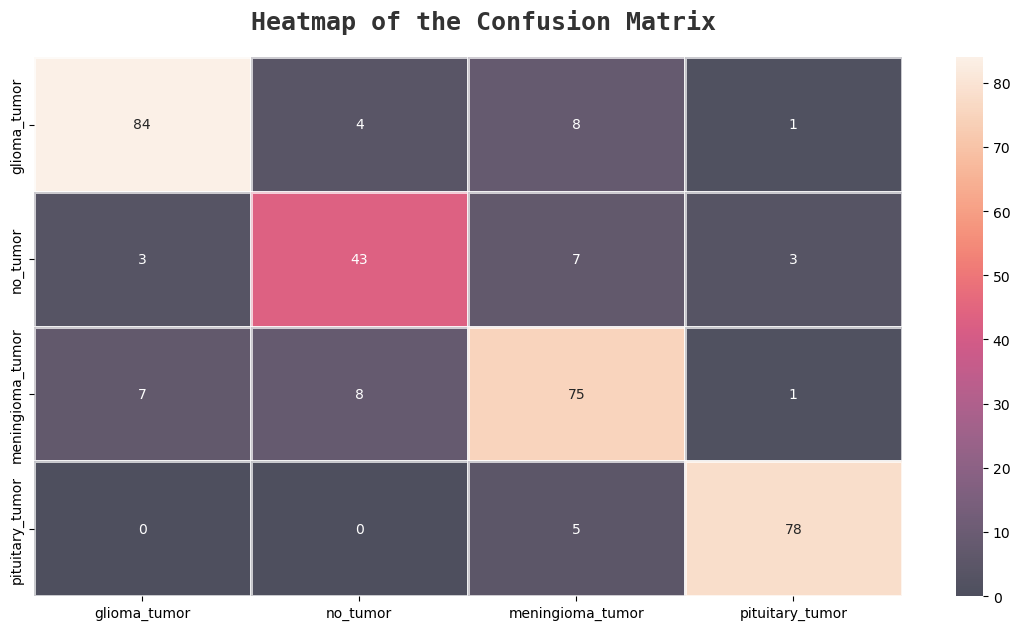

In [35]:
fig,ax=plt.subplots(1,1,figsize=(14,7))

sns.heatmap(confusion_matrix(y_test_new,y_pred), 
            ax=ax,
            xticklabels=labels, 
            yticklabels=labels, 
            annot=True,
            # cmap=colors_green[::-1],
            alpha=0.7,linewidths=2,
            # linecolor=colors_dark[3]
           )

fig.text(s='Heatmap of the Confusion Matrix',
         size=18,
         fontweight='bold',
         fontname='monospace',
         # color=colors_dark[1],
         y=0.92,
         x=0.28,
         alpha=0.8)

plt.show()